In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import seaborn as sns
import os
import tqdm
import matplotlib.pyplot as plt
import re 
from collections import Counter
import sys
sys.path.insert(0,'../')
from utils.reading_utils import *
from utils.embeddings_utils import *
from utils.processing_utils import *
sns.set()

# Data loading

In [2]:
ABS_PATH = '../data/cornell/cornell movie-dialogs corpus'

# Processing movie_lines.txt

In [3]:
movie_lines = read_chameleons(os.path.join(ABS_PATH,'movie_lines.txt'), ['lineID', 'charID', 'movieID','char_name', 'utter'])

In [4]:
movie_lines.head()

,lineID,charID,movieID,char_name,utter
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [5]:
movie_lines['utter'] = movie_lines['utter'].apply(cut_punctuation)

In [6]:
movie_lines['utter'] = movie_lines['utter'].apply(clean_bad_chars)

In [7]:
word_counts = Counter(np.hstack(movie_lines['utter'].apply(lambda x: x.split(' ')).values))
len(word_counts)

68256

In [8]:
token_counts = Counter(np.hstack(movie_lines['utter'].apply(lambda x: x.split(' '))))


In [9]:
movie_lines['utter'] = movie_lines['utter'].apply(lambda x: x.lower())

In [10]:
movie_lines['utter'] = movie_lines['utter'].apply(uncover_reduction)

In [11]:
movie_lines['utter']

0                                             they do not !
1                                              they do to !
2                                               i hope so .
3                                                she okay ?
4                                                 lets go .
                                ...                        
304708    lord chelmsford seems to want me to stay back ...
304709    i am to take the sikali with the main column t...
304710                             your orders mr vereker ?
304711    good ones yes mr vereker . gentlemen who can r...
304712    colonel durnford . william vereker . i hear yo...
Name: utter, Length: 304713, dtype: object

In [12]:
word_counts = Counter(np.hstack(movie_lines['utter'].apply(lambda x: x.split(' ')).values))


In [13]:
len(word_counts)

50168

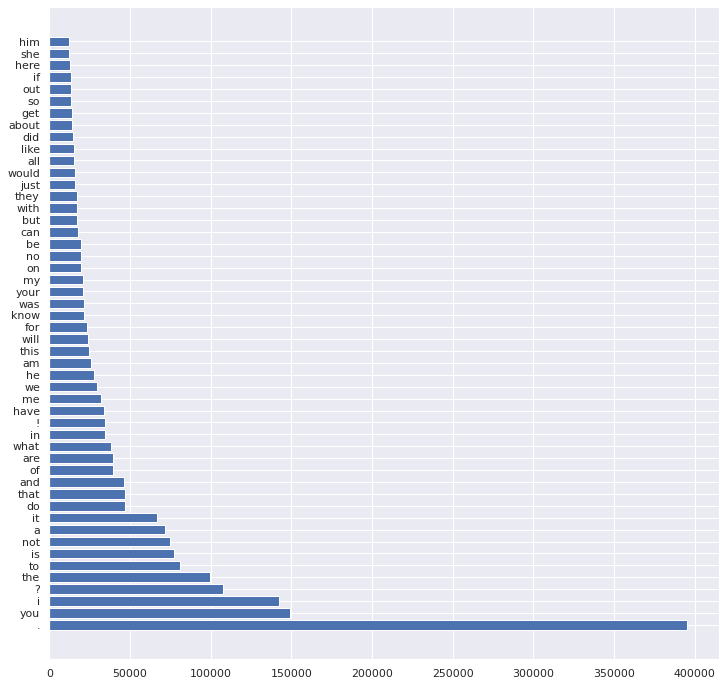

In [14]:
top_50_tokens, counts = zip(*sorted(word_counts.items(), key=lambda x: x[1])[::-1][:50])
plt.figure(figsize=(12,12))
plt.barh(range(len(top_50_tokens)), counts)
plt.yticks(range(len(top_50_tokens)),top_50_tokens);

In [15]:
(movie_lines['utter']=='').astype(int).sum()

269

In [16]:
movie_lines = movie_lines[movie_lines['utter'].apply(lambda x: True if x else False)]

In [17]:
(movie_lines['utter']=='').astype(int).sum()

0

# Movie conversations loading and processing 

In [18]:
movie_conversations = read_chameleons(os.path.join(ABS_PATH,'movie_conversations.txt'),
                                      columns = ['charID_1', 'charID_2', 'movieID', 'conversation'])

In [19]:
movie_conversations.head()

,charID_1,charID_2,movieID,conversation
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']"
1,u0,u2,m0,"['L198', 'L199']"
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']"
3,u0,u2,m0,"['L204', 'L205', 'L206']"
4,u0,u2,m0,"['L207', 'L208']"


In [20]:
movie_conversations['conversation'] = movie_conversations['conversation'].apply(lambda x: json.loads(x.replace("'",'"')))

In [21]:
utters = movie_lines[['lineID','utter']].set_index('lineID').to_dict('dict')['utter']

In [22]:
movie_conversations['conversation'] = movie_conversations['conversation'].apply(lambda x : [utters.get(i) for i in x if utters.get(i)])

In [23]:
conversations = movie_conversations['conversation'].values

In [24]:
conversations[:2]

array([list(['can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .', 'well i thought we would start with pronunciation if that is okay with you .', 'not the hacking and gagging and spitting part . please .', 'okay . then how about we try out some french cuisine . saturday ? night ?']),
       list(['you are asking me out . that is so cute . what is your name again ?', 'forget it .'])],
      dtype=object)

In [25]:
import gc
del utters, movie_conversations, movie_lines;
gc.collect();

# Processing of conversations and mapping creation

In [26]:
unique_tokens = Counter(np.hstack([i.split(' ') for i in np.hstack(conversations)]))

In [27]:
max_tokens = 30000

In [28]:
rare_tokens, _ = zip(*sorted(unique_tokens.items(), key=lambda x: x[1])[::-1][-(len(unique_tokens)-max_tokens):])

In [29]:
len(unique_tokens), len(rare_tokens)

(50168, 20168)

In [30]:
unk_token = '<unk>'
unk_dict = dict((i,unk_token) for i in rare_tokens)

In [31]:
conversations = replace_in_conversations(conversations, unk_dict)

In [32]:
lengths_dialogues = list(map(len,conversations))
Counter(lengths_dialogues)

Counter({4: 9485,
         2: 38061,
         3: 17448,
         5: 5891,
         8: 1559,
         6: 3724,
         7: 2378,
         9: 1209,
         1: 45,
         11: 587,
         10: 711,
         16: 151,
         18: 71,
         15: 203,
         13: 346,
         12: 422,
         21: 44,
         22: 35,
         17: 121,
         14: 222,
         19: 76,
         28: 23,
         26: 17,
         20: 55,
         34: 5,
         23: 32,
         27: 18,
         41: 2,
         33: 7,
         29: 9,
         24: 30,
         54: 1,
         36: 5,
         38: 6,
         30: 14,
         32: 8,
         35: 3,
         31: 7,
         37: 2,
         45: 2,
         53: 1,
         25: 26,
         43: 2,
         39: 3,
         40: 2,
         49: 1,
         44: 2,
         52: 2,
         89: 1,
         42: 1,
         55: 1,
         56: 1,
         59: 1})

In [33]:
conversations = [i for i in conversations if len(i)>1]

In [34]:
unique_tokens = np.unique(np.hstack([i.split(' ') for i in np.hstack(conversations)]))

In [35]:
pad_token = '<pad>'
start_token = '<start>'
end_token = '<end>'
token_mapping = {pad_token:0, 
                start_token:1,
                end_token:2,
                unk_token:3}
start_point = 3
for token in unique_tokens:
    if not token_mapping.get(token):
        start_point+=1
        token_mapping.update({token:start_point})

In [36]:
len(token_mapping)

30004

# Creation of embeddings matrix

In [37]:
import gensim
import tqdm

In [50]:
data_path = '../processed_data'
if not os.path.exists(data_path):
    os.mkdir(data_path)

## w2v embeddings

In [39]:
embeddings = load_emb_from_disk('../embeddings/GoogleNews-vectors-negative300.bin')

In [40]:
tokens_embs, missing = get_emb_rep(list(token_mapping.keys()), embeddings)

100%|██████████| 30003/30003 [00:00<00:00, 634087.82it/s]

4955 words where absent in embedding


In [41]:
final_embeddings = create_embeddings(tokens_embs, token_mapping, pad_token)

In [42]:
with open(os.path.join(data_path,'w2v_embeddings_cornell.npy'), 'wb') as f:
    np.save(f, final_embeddings)

with open(os.path.join(data_path,'missing_in_w2v_cornell.npy'), 'wb') as f:
    np.save(f, missing)


In [43]:
final_embeddings.shape

(30003, 300)

In [44]:
import gc;
del final_embeddings
gc.collect();

In [45]:
del embeddings;
gc.collect();

## glove embeddings

In [46]:
glove_vectors = load_glove('../embeddings/glove.6B.100d.txt')

Loading Glove Model
400000  words loaded!


In [47]:
len(glove_vectors)

400000

In [48]:
tokens_embs, missing = get_emb_rep_glove(list(token_mapping.keys()), glove_vectors)

100%|██████████| 30003/30003 [00:00<00:00, 1136843.03it/s]

2138 words where absent in embedding


In [49]:
final_embeddings = create_embeddings(tokens_embs, token_mapping, pad_token)

In [50]:
with open(os.path.join(data_path,'glove_embeddings_cornell.npy'), 'wb') as f:
    np.save(f, final_embeddings)

with open(os.path.join(data_path,'missing_in_glove_cornell.npy'), 'wb') as f:
    np.save(f, missing)


In [51]:
del final_embeddings;
gc.collect();

## Training custom glove embeddings

In [37]:
glove_input = np.hstack(conversations)
glove_input = [i.split(' ') for i in glove_input]

In [38]:
glove_input[:1]

[['can',
  'we',
  'make',
  'this',
  'quick',
  '?',
  '<unk>',
  '<unk>',
  'and',
  'andrew',
  'barrett',
  'are',
  'having',
  'an',
  'incredibly',
  'horrendous',
  'public',
  'break',
  'up',
  'on',
  'the',
  '<unk>',
  '.',
  'again',
  '.']]

In [39]:
from glove import Glove, Corpus

In [40]:
corpus = Corpus()
corpus.fit(glove_input)
glove = Glove(no_components=100, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=100, no_threads=6, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 100 training epochs with 6 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [41]:
glove.most_similar('hello')

[('hi', 0.7993940299103071),
 ('goodbye', 0.7771417995183715),
 ('say', 0.6487433162394438),
 ('harry', 0.576638942409133)]

In [42]:
glove.most_similar('fuck')

[('hell', 0.7030711131135966),
 ('shit', 0.6648535818848899),
 ('fucking', 0.6370489808167479),
 ('misha', 0.63039261868781)]

In [44]:
glove.most_similar('usa')

[('lookink', 0.752405588441274),
 ('goodridge', 0.7402130511479282),
 ('mclean', 0.7346840406194368),
 ('canaries', 0.7317034458885079)]

In [45]:
glove.most_similar('jack')

[('joe', 0.7402086843914472),
 ('george', 0.7303346020710688),
 ('sam', 0.6854750447005393),
 ('rose', 0.6748534222022888)]

In [46]:
tokens = list(glove.dictionary.keys())
print(len(tokens))
glove_vectors = dict([(tokens[idx],vector) for idx, vector in enumerate(glove.word_vectors)])

30001


In [47]:
tokens_embs, missing = get_emb_rep_glove(list(token_mapping.keys()), glove_vectors)

100%|██████████| 30004/30004 [00:00<00:00, 575758.77it/s]

3 words where absent in embedding


In [48]:
final_embeddings = create_embeddings(tokens_embs, token_mapping, pad_token)

In [51]:
with open(os.path.join(data_path,'glove_embeddings_trained_cornell.npy'), 'wb') as f:
    np.save(f, final_embeddings)

with open(os.path.join(data_path,'missing_in_glove_trained_cornell.npy'), 'wb') as f:
    np.save(f, missing)


## saving out

In [52]:

with open(os.path.join(data_path,'token_mapping_cornell.json'), 'w') as f:
    json.dump(token_mapping, f)

with open(os.path.join(data_path,'data_cornell.npy'), 'wb') as f:
    np.save(f, conversations)  

/home/volodymyr/envs/convbot_env/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
